In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

from configs import CONF
import numpy as np

import matplotlib.pyplot as plt
import json

import pandas as pd
import re

from utils.sdf import SDF
import torch
import cv2

In [2]:
# losses = os.listdir(CONF.LOG_PATH)
# for loss in losses:
#     with open(f'{CONF.LOG_PATH}/{loss}', 'r') as f:
#         logfile = json.load(f)

#     for key in list(logfile.keys()):
#         if 'metrics' in key:
#             old_key = re.split('/|-', key)
#             if old_key[1] == 'DSC':
#                 old_key[1] = 'sDSC'
#             if old_key[1] == 'JCC':
#                 old_key[1] = 'IoU'
#             new_key = f"{old_key[0]}-{old_key[2]}/{old_key[1]}"
#             logfile[new_key] = logfile.pop(key)

#     with open(f'{CONF.LOG_PATH}/{loss}', 'w') as f:
#         json.dump(logfile, f)

In [ ]:
def calc_CMA(logfile):
    DSC = np.array(logfile['metrics-test/sDSC'])
    IoU = np.array(logfile['metrics-test/IoU'])
    ASD = np.array(logfile['metrics-test/ASD'])
    AD = np.array(logfile['metrics-test/AD'])

    cma = (DSC + IoU  + (1 - AD))/3
    cma = np.round(cma, 4)
    return cma
    

def get_window_idx(wsize, i):
    left = max(0, i - wsize)
    right = min(CONF.TRAIN_EPOCHS, i + wsize + 1)
    return left, right

def aggregate_results(losses, wsize):
    metrics = {'CMA': max, 'sDSC': max, 'IoU': max, 'ASD': min,'AD': min, 'HD95': min}
    results = {name:{} for name, _ in metrics.items()}
    wsize = wsize//2

    for loss in losses:
        with open(f'{CONF.LOG_PATH}/{loss}.json', 'r') as f:
            logfile = json.load(f)
        # logfile[f'metrics-test/CMA'] = calc_CMA(logfile)

        for key, func in metrics.items():
            acc = logfile[f'metrics-test/{key}']

            avg = []
            for i in range(len(acc)):
                l, r = get_window_idx(wsize, i)
                avg.append(np.mean(acc[l:r]))

            i = avg.index(func(avg))
            l, r = get_window_idx(wsize, avg.index(func(avg))) 
            results[key][loss] = {'min': min(acc), 'max': max(acc), 'window':acc[l:r]}
    return results

def prepare_data(data, metric, sort = True):
    labels = data[metric].keys()
    data = [val['window'] for _, val in data[metric].items()]

    cmap = plt.get_cmap('tab20')
    cmap = [[cmap(2*i), cmap(2*i+1)] for i in range(len(labels))]
    med = [np.median(loss) for loss in data]
    if sort: 
        _, data, labels, cmap = zip(*sorted(zip(med, data, labels, cmap)))
    
    if metric in ['ASD','AD','HD95']:
        data = [[round(val*133,1) for val in lst] for lst in data]
    else:
        data = [[round(val*100,1) for val in lst] for lst in data]
    return data, labels, cmap

def color_boxs(plot, cmap):
    for i in range(len(cmap)):
        ec, fc = cmap[i]
        plot['boxes'][i].set(facecolor=fc, edgecolor=ec)
        plot['medians'][i].set(color='black', linewidth=1)

        for j in [2*i, 2*i +1]:
            plot['whiskers'][j].set(color=ec, linewidth=1)
            plot['caps'][j].set(color=ec, linewidth=1)


In [44]:
losses = ['softDICE', 'softDICE-cmp', 'BCE', 'wBCE', 'MAE', 'cMAE', 'sMAE', 'DICE_MAE', 'DICE_cMAE', 'DICE_sMAE']
factor = 0.5
positions = factor*np.arange(1, len(losses)+1)
xmin = positions[0] - factor
xmax = positions[-1] + factor


results = aggregate_results(losses, 41)
data, _, cmap = prepare_data(results, 'ASD', sort = False)

In [45]:
def plot_boxes(ax, data, ylims, cmap, labels, lname = None, y_axis = 'left', bottom = False, title = None):

    boxplot = ax.boxplot(data, patch_artist=True, showfliers= False, positions=positions, widths=0.45)
    color_boxs(boxplot, cmap)

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=1, zorder=1)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ylims[0], ylims[1])

    if y_axis == 'right':
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.spines[['top','left']].set_visible(False)
        ax.spines['right'].set_linewidth(1.1)
    elif y_axis == 'left':
        ax.spines[['top','right']].set_visible(False)
        ax.spines['left'].set_linewidth(1.1)

    if bottom:
        ax.set_xticklabels(labels, rotation = 90)
    else:
        ax.spines[['bottom']].set_visible(False)
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks_position('none') 

    ax.set_ylabel(lname, fontsize=15, labelpad=5)
    if title is not None:
        ax.set_title(title, loc = 'center', pad = 15, fontsize = 15)


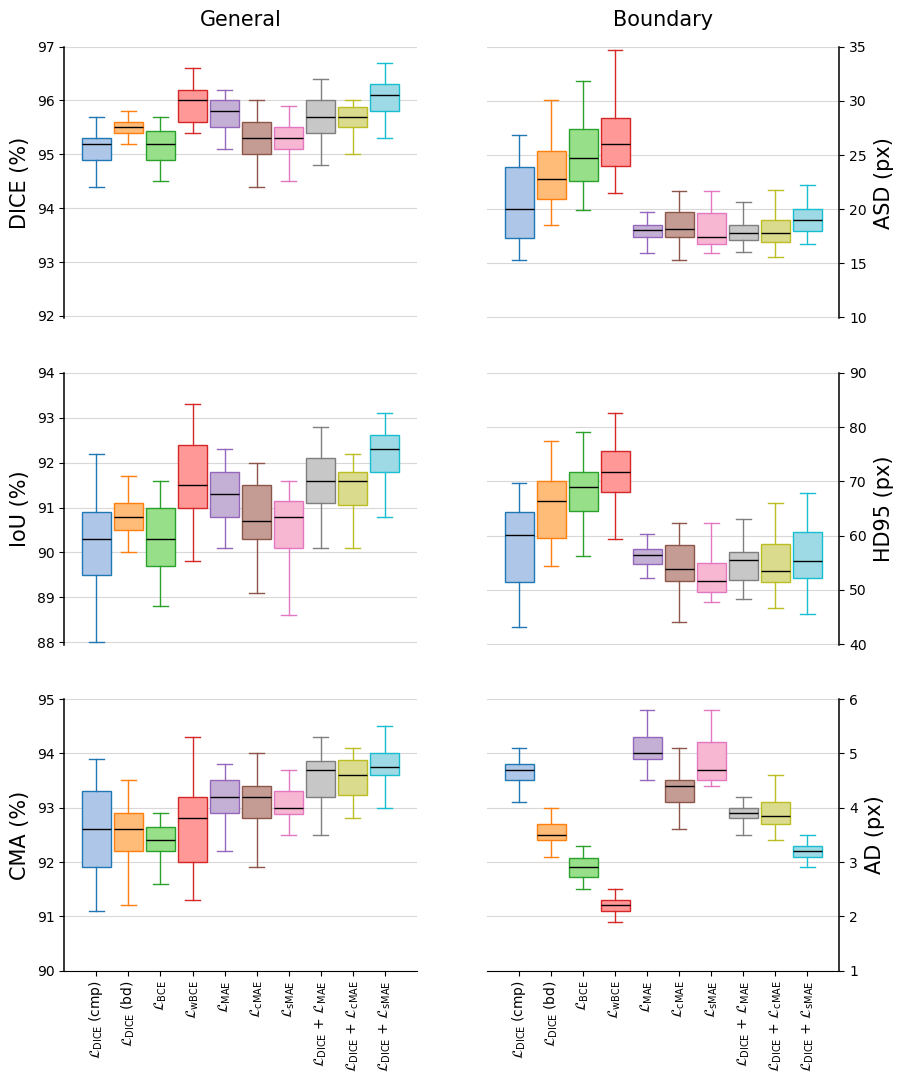

In [67]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

losses = ['softDICE-cmp', 'softDICE', 'BCE', 'wBCE', 'MAE', 'cMAE', 'sMAE', 'DICE_MAE', 'DICE_cMAE', 'DICE_sMAE']
labels  = ['$\mathcal{L}_{\\text{DICE}}\\;\\text{(cmp)}$', 
           '$\mathcal{L}_{\\text{DICE}}\\;\\text{(bd)}$', 
           '$\mathcal{L}_{\\text{BCE}}$', 
           '$\mathcal{L}_{\\text{wBCE}}$', 
           '$\mathcal{L}_{\\text{MAE}}$', 
           '$\mathcal{L}_{\\text{cMAE}}$', 
           '$\mathcal{L}_{\\text{sMAE}}$', 
           '$\mathcal{L}_{\\text{DICE}}$ + $\mathcal{L}_{\\text{MAE}}$', 
           '$\mathcal{L}_{\\text{DICE}}$ + $\mathcal{L}_{\\text{cMAE}}$', 
           '$\mathcal{L}_{\\text{DICE}}$ + $\mathcal{L}_{\\text{sMAE}}$']


results = aggregate_results(losses, 40)

data, _, cmap = prepare_data(results, 'sDSC', sort = False)
plot_boxes(ax[0][0], data, (91.95, 97), cmap, labels, 'DICE (%)', title = 'General')

data, _, cmap = prepare_data(results, 'IoU', sort = False)
plot_boxes(ax[1][0], data, (87.95, 94), cmap, labels, 'IoU (%)')

data, _, cmap = prepare_data(results, 'CMA', sort = False)
plot_boxes(ax[2][0], data, (90, 95), cmap, labels, 'CMA (%)', bottom=True)

data, _, cmap = prepare_data(results, 'ASD', sort = False)
# plot_boxes(ax[0][1], data, (0.099, 0.28), cmap, labels, 'ASD', y_axis = 'right', title = 'Boundary')
plot_boxes(ax[0][1], data, (9.9, 35), cmap, labels, 'ASD (px)', y_axis = 'right', title = 'Boundary')

data, _, cmap = prepare_data(results, 'HD95', sort = False)
# plot_boxes(ax[1][1], data, (0.298, 0.65), cmap, labels, 'HD95', y_axis = 'right')
plot_boxes(ax[1][1], data, (39.9, 90), cmap, labels, 'HD95 (px)', y_axis = 'right')


data, _, cmap = prepare_data(results, 'AD', sort = False)
# plot_boxes(ax[2][1], data, (0.01, 0.06), cmap, labels, 'AD', y_axis = 'right', bottom=True)
plot_boxes(ax[2][1], data, (1, 6), cmap, labels, 'AD (px)', y_axis = 'right', bottom=True)

plt.savefig("metrics_new.png", format="png", bbox_inches="tight", dpi=200)

In [ ]:
# losses = [f.split('-')[0] for f in os.listdir(CONF.MDL_PATH) if f.endswith('json')]
losses = [f for f in os.listdir(CONF.MDL_PATH) if f.endswith('json')]
df = pd.DataFrame()

# for loss in losses:
#     # with open(f'{CONF.MDL_PATH}/{loss}-F{CONF.FOLD_ID}.json', 'r') as f:
#     #     best = json.load(f)
#     with open(f'{CONF.MDL_PATH}/{loss}', 'r') as f:
#         best = json.load(f)
#     # best['metrics-test/CMA'] = calc_CMA(best)

#     best = {re.split('/', key)[1]:val for key, val in best.items() if key != 'epoch'}
#     bestB = {key:round(val*100, 1) for key, val in best.items() if key in ['CMA', 'sDSC', 'IoU']}
#     bestR = {key:round(val*133, 1) for key, val in best.items() if key in ['ASD', 'AD', 'HD95']}
#     best = bestB | bestR
#     best['loss'] = loss

#     df = pd.concat([df, pd.DataFrame([best])], ignore_index=True)
# df.drop(columns=[key for key in best.keys() if key.endswith('train')], inplace=True)

In [17]:
methods = ['method3_enc.json', 'method1.json','method2_cls.json','method3_cls.json']
df = pd.DataFrame()

for meth in methods:
    with open(f'{CONF.MDL_PATH}/{meth}', 'r') as f:
        best = json.load(f)
    best = {re.split('/', key)[1]:val for key, val in best.items() if key != 'epoch'}
    bestB = {key:round(val*100, 1) for key, val in best.items() if key in ['TTR','CMA', 'DSC', 'IoU']}
    bestR = {key:round(val*133, 1) for key, val in best.items() if key in ['ASD', 'AD', 'HD95']}
    best = bestB | bestR
    best['meth'] = meth
    df = pd.concat([df, pd.DataFrame([best])], ignore_index=True)

df.drop(columns=[key for key in best.keys() if key.endswith('train')], inplace=True)

In [22]:
df.iloc[0] = [None, 93.5, 96.7, 93.7, 20.0, 5.1, 58.5, 'xxxx']

In [23]:
df 

,TTR,CMA,DSC,IoU,ASD,AD,HD95,meth
0,NaN,93.5,96.7,93.7,20.0,5.1,58.5,xxxx
1,93.8,94.8,97.9,95.9,21.0,2.6,60.4,method1.json
2,87.5,92.1,96.1,92.6,26.6,5.6,80.8,method2_cls.json
3,94.0,95.0,98.0,96.1,18.3,3.4,61.4,method3_cls.json


In [21]:
0.03855*133

5.12715

In [ ]:
with open(CONF.TTS_FILE) as f:
    TTS = json.load(f)
testIDs = TTS[str(2)][f'{CONF.TEST}_test']

mask_batch = []
imID_batch = []
means = 0 
batch_len = 0
for i, imID in enumerate(testIDs):
    mask = cv2.imread(f'{CONF.MASK_DATASET_PATH}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%CONF.BATCH_SIZE == 0 or i == len(testIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.tensor(mask_batch).to(torch.float32).unsqueeze(1)
        mask_batch_tensor = mask_batch_tensor.to(CONF.DEFAULT_DEVICE)

        SDMs = SDF(mask_batch_tensor, kernel_size = 7)
        B = SDMs.shape[0]
        means += torch.mean(SDMs.view(B, 1, -1).mean(dim=2))
        batch_len += 1

        mask_batch = []
        imID_batch = []

In [9]:
means/batch_len

tensor(133.0432, device='cuda:0')

In [4]:
(0.023*133)*2.5

7.647500000000001

In [3]:
(0.029*133)*2.5

9.6425